In [7]:
p = [-0.01384403471488191, -0.006703473186008027, 0.01124338542563214, -0.0018447160242865432, -0.009750015407201894, -0.014971492735459604, 0.9998386813019494]

from trajectory_utils import create_homogeneous_matrix, translation_from_matrix, quaternion_from_matrix

delta_cam = create_homogeneous_matrix(p[:3], p[3:])
delta_cam

array([[ 0.99936158,  0.02997413, -0.01944165, -0.01384403],
       [-0.02990218,  0.9995449 ,  0.00398078, -0.00670347],
       [ 0.01955212, -0.00339689,  0.99980307,  0.01124339],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [8]:
p = [0.5467240034794747,
    0.07308975984247558,
    0.47843080600627036,
    -0.9972096440434232,
    -0.023757100384893235,
    -0.06755564051390728,
    0.021089368004929353]

p = create_homogeneous_matrix(p[:3], p[3:])
p

array([[ 0.98974367,  0.05023103,  0.13373223,  0.546724  ],
       [ 0.04453221, -0.99798168,  0.04527089,  0.07308976],
       [ 0.13573632, -0.03885119, -0.98998295,  0.47843081],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [2]:
import numpy as np

extr = np.load("handeye/T_C_EEF_wrist_l.npy")
intr = np.load("handeye/intrinsics_d405.npy")

In [9]:
g = p @ extr @  delta_cam
translation_from_matrix(g), quaternion_from_matrix(g)

(array([ 5.81602659e-01, -4.11032233e-04,  4.34927401e-01]),
 array([-0.05171688,  0.99592506, -0.01054581,  0.07312605]))

In [9]:
intr

array([[-0.99950681, -0.03010772, -0.00892518,  0.0114041 ],
       [ 0.02947871, -0.99752916,  0.06376976,  0.0697988 ],
       [-0.01082309,  0.0634752 ,  0.99792473,  0.0334602 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

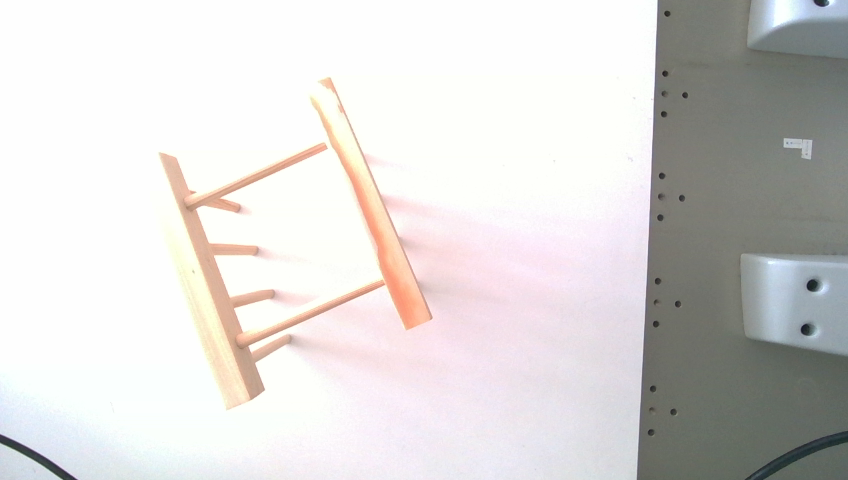

In [16]:
import rospy
import ros_numpy
import matplotlib.pyplot as plt
import numpy as np
from sensor_msgs.msg import Image as ImageMsg
from PIL import Image

rospy.init_node('dino', anonymous=True)

rgb_message_wrist = rospy.wait_for_message("d405/color/image_rect_raw", ImageMsg)
depth_message_wrist = rospy.wait_for_message("d405/aligned_depth_to_color/image_raw", ImageMsg)
rgb_data_wrist = ros_numpy.numpify(rgb_message_wrist)
depth_data_wrist = ros_numpy.numpify(depth_message_wrist)
rgb_image_wrist = Image.fromarray(rgb_data_wrist)
depth_image_wrist = Image.fromarray(depth_data_wrist)
rgb_image_wrist

In [4]:
from trajectory_utils import create_homogeneous_matrix, pose_inv, translation_from_matrix, quaternion_from_matrix
import numpy as np
T = np.eye(4)
print(translation_from_matrix(T).tolist() + quaternion_from_matrix(T).tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [13]:
T_camera_eef = np.load("handeye/T_C_EEF_wrist_l.npy")

T_camera_eef

array([[-0.99933956, -0.03374286, -0.01348565,  0.0113209 ],
       [ 0.03292706, -0.99784706,  0.05671903,  0.0716074 ],
       [-0.01537048,  0.05623753,  0.9982991 ,  0.0336167 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [14]:
delta_camera = T
T_new_eef_world = T @ T_camera_eef @ delta_camera @ pose_inv(T_camera_eef)
xyz = translation_from_matrix(T_new_eef_world).tolist()
quaternion = quaternion_from_matrix(T_new_eef_world).tolist()

In [21]:
DIR = "data/wood"

rgb_image_wrist.save(f"{DIR}/live_wrist_rgb.png")
depth_image_wrist.save(f"{DIR}/live_wrist_depth.png")

Using cache found in /home/yilong/.cache/torch/hub/facebookresearch_dino_main


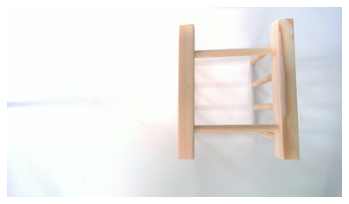

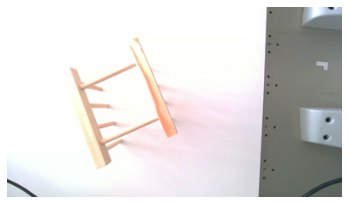

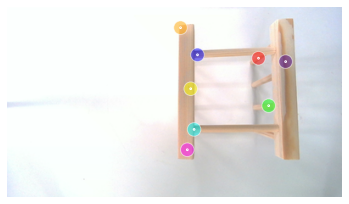

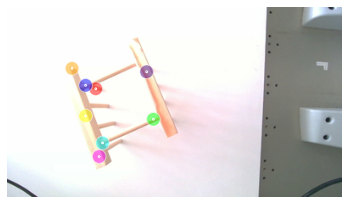

((-0.026914832310566607, -0.0010070975963056296, 0.015953726103354653),
 array([[ 0.94746213,  0.31218137, -0.06970147],
        [-0.30489345,  0.94729712,  0.09832671],
        [ 0.09672377, -0.07190931,  0.99271021]]),
 872.5078796205797)

In [22]:
from dinobotAlignment import DINOBotAlignment

dinobotAlignment = DINOBotAlignment(DIR=DIR)
demo_rgb = "{0}/demo_wrist_rgb.png".format(DIR)
live_rgb = "{0}/live_wrist_rgb.png".format(DIR)
demo_depth = "{0}/demo_wrist_depth.png".format(DIR)
live_depth = "{0}/live_wrist_depth.png".format(DIR)

t, R, error = dinobotAlignment.run(live_rgb, live_depth)
t, R, error

In [ ]:
R

In [25]:
from scipy.spatial.transform import Rotation

r = Rotation.from_matrix(R)
quaternion = r.as_quat()

quaternion

array([-0.04317059, -0.0422042 , -0.15648559,  0.98583334])

Using cache found in /home/yilong/.cache/torch/hub/facebookresearch_dino_main
/home/yilong/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


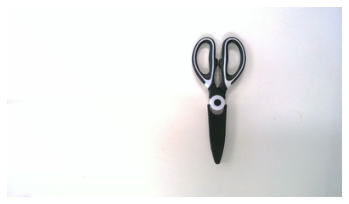

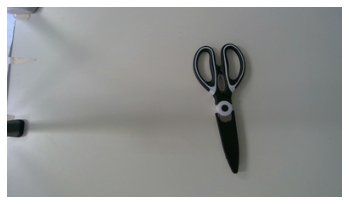

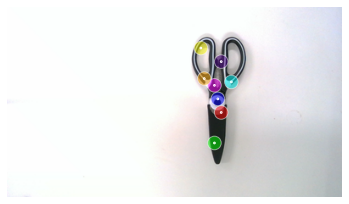

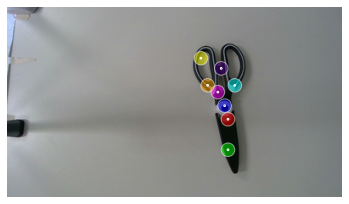

In [124]:
import matplotlib.pyplot as plt
import torch
from DinoViT.correspondences import find_correspondences, draw_correspondences

num_pairs = 8 #@param
load_size = 224 #@param
layer = 9 #@param
facet = 'key' #@param
bin=True #@param
thresh=0.05 #@param
model_type='dino_vits8' #@param
stride=4 #@param

image_path1=f"{DIR}demo_wrist_rgb.png"
image_path2=f"{DIR}/live_wrist_rgb.png"

with torch.no_grad():
    points1, points2, image1_pil, image2_pil = find_correspondences(image_path1, image_path2, num_pairs, load_size, layer,
                                                                   facet, bin, thresh, model_type, stride)
fig_1, ax1 = plt.subplots()
ax1.axis('off')
ax1.imshow(image1_pil)
fig_2, ax2 = plt.subplots()
ax2.axis('off')
ax2.imshow(image2_pil)


fig1, fig2 = draw_correspondences(points1, points2, image1_pil, image2_pil)
plt.show()

In [31]:
np.array(image1_pil).shape

(224, 395, 3)

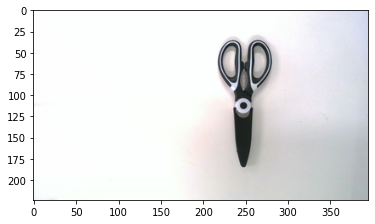

In [32]:
plt.imshow(image1_pil, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.show()

531.4285714285714 223.2708860759494
488.57142857142856 103.04810126582278
522.8571428571428 309.14430379746835
582.8571428571428 163.15949367088606
522.8571428571428 223.2708860759494
540.0 283.3822784810127
522.8571428571428 231.85822784810128
557.1428571428572 188.92151898734176


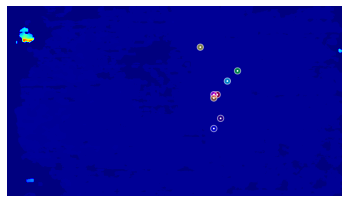

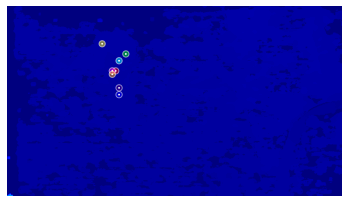

In [40]:
from matplotlib.colors import ListedColormap
cmap = plt.cm.jet  # You can use any colormap you prefer
# Normalize depth values between 0 and 1 for colormap
norm = plt.Normalize(vmin=np.min(np.concatenate([demo_depth, live_depth])), vmax=np.max(np.concatenate([demo_depth, live_depth])))
num_points = len(points1)
fig1, ax1 = plt.subplots()
ax1.axis('off')
fig2, ax2 = plt.subplots()
ax2.axis('off')
ax1.imshow(demo_depth, cmap=cmap, norm=norm)
ax2.imshow(live_depth, cmap=cmap, norm=norm)
if num_points > 15:
    cmap = plt.get_cmap('tab10')
else:
    cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                            "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
colors = np.array([cmap(x) for x in range(num_points)])
radius1, radius2 = 8, 1
for point1, point2, color in zip(points1, points2, colors):
    y1, x1 = point1
    circ1_1 = plt.Circle((x1 / 224 * 480, y1 / 395 * 848), radius1, facecolor=color, edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x1 / 224 * 480, y1 / 395 * 848), radius2, facecolor=color, edgecolor='white')
    print(x1 / 224 * 480, y1 / 395 * 848)
    ax1.add_patch(circ1_1)
    ax1.add_patch(circ1_2)
    y2, x2 = point2
    circ2_1 = plt.Circle((x2 / 224 * 480, y2 / 395 * 848), radius1, facecolor=color, edgecolor='white', alpha=0.5)
    circ2_2 = plt.Circle((x2 / 224 * 480, y2 / 395 * 848), radius2, facecolor=color, edgecolor='white')
    ax2.add_patch(circ2_1)
    ax2.add_patch(circ2_2)

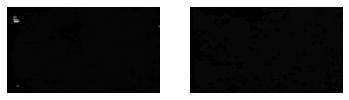

In [43]:
# Normalize depth values between 0 and 1
depth_min = min(np.min(demo_depth), np.min(live_depth))
depth_max = max(np.max(demo_depth), np.max(live_depth))

# Create subplots for visualization
fig, (ax1, ax2) = plt.subplots(1, 2)

# Remove axes
ax1.axis('off')
ax2.axis('off')

# Visualize depth maps using grayscale colormap
ax1.imshow(demo_depth, cmap='gray', vmin=depth_min, vmax=depth_max)
ax2.imshow(live_depth, cmap='gray', vmin=depth_min, vmax=depth_max)

# Show the plots
plt.show()


In [52]:
points1

[(128, 248),
 (92, 264),
 (84, 248),
 (52, 244),
 (108, 244),
 (108, 248),
 (128, 240),
 (88, 236)]

In [53]:
points2

[(128, 232),
 (88, 248),
 (84, 232),
 (52, 224),
 (108, 228),
 (108, 232),
 (128, 224),
 (88, 220)]

In [128]:
import numpy as np
from PIL import Image
DIR = "scissor"
demo_rgb = np.array(Image.open("data/{0}/demo_wrist_rgb.png".format(DIR)))
live_rgb = np.array(Image.open("data/{0}/live_wrist_rgb.png".format(DIR)))
demo_depth = np.array(Image.open("data/{0}/demo_wrist_depth.png".format(DIR)))
live_depth = np.array(Image.open("data/{0}/live_wrist_depth.png".format(DIR)))

In [129]:
def add_depth(points, depth):
    """
    Inputs:
        points: list of [x, y] pixel coordinates
        depth (H, W, 1): numpy array representing depth observations from camera.
    Outputs:
        point_with_depth: list of [x, y, z] coordinates where z is the depth value
    """
    point_with_depth = []
    for (y, x) in points:
        x = int(x / np.array(image1_pil).shape[0] * demo_rgb.shape[0])
        y = int(y / np.array(image1_pil).shape[1] * demo_rgb.shape[1])
        print(x,y)
        point_with_depth.append([x, y, depth[y, x]])

    
    return point_with_depth

def compute_error(points1, points2):
	return np.linalg.norm(np.array(points1) - np.array(points2))

In [79]:
np.array(image1_pil).shape[0], demo_rgb.shape[0]

(224, 480)

In [71]:
np.array(image1_pil).shape[0]

224

In [31]:
demo_depth.shape

(480, 848)

In [130]:
points1_with_depth = add_depth(points1, demo_depth)
print(points1_with_depth)

540 266
488 103
531 231
522 343
522 197
540 137
497 180
565 188
[[540, 266, 286], [488, 103, 294], [531, 231, 282], [522, 343, 279], [522, 197, 284], [540, 137, 287], [497, 180, 290], [565, 188, 281]]


In [131]:
points2_with_depth = add_depth(points2, live_depth)
print(points2_with_depth)

557 283
488 128
548 249
557 360
531 214
540 154
505 197
574 197
[[557, 283, 282], [488, 128, 299], [548, 249, 283], [557, 360, 272], [531, 214, 287], [540, 154, 295], [505, 197, 291], [574, 197, 287]]


In [132]:
def find_transformation(X, Y):
    #Find transformation given two sets of correspondences between 3D points
    # Calculate centroids
    cX = np.mean(X, axis=0)
    cY = np.mean(Y, axis=0)
    # Subtract centroids to obtain centered sets of points
    Xc = X - cX
    Yc = Y - cY
    # Calculate covariance matrix
    C = np.dot(Xc.T, Yc)
    # Compute SVD
    U, S, Vt = np.linalg.svd(C)
    # Determine rotation matrix
    R = np.dot(Vt.T, U.T)
    # Determine translation vector
    t = cY - np.dot(R, cX)
    return R, t

R, t = find_transformation(points1_with_depth, points2_with_depth)
print(R)
print(t)

[[ 0.98727082  0.14264376 -0.07034976]
 [-0.13715022  0.98750789  0.07757565]
 [ 0.08053662 -0.06693969  0.99450135]]
[  9.31071437  69.6451222  -25.37340926]


In [133]:
intrinsics_d405 = np.load("handeye/intrinsics_d405.npy")

def convert_pixels_to_meters(t):
    """
    Converts translation from pixel coordinates to world coordinates in meters.
    
    Inputs:
        t (tuple): (x, y, z) translation of the end-effector in pixel-space.
        focal_length (float): Focal length of the camera in pixels.
        pixel_size (float): Size of one pixel in meters.
        principal_point (tuple): (cx, cy) the principal point of the camera in pixels.
        
    Outputs:
        t_meters (tuple): (x, y, z) translation of the end-effector in meters.
    """
    fx, fy = intrinsics_d405[0, 0], intrinsics_d405[1, 1]
    cx, cy =  intrinsics_d405[0, 2],  intrinsics_d405[1, 2]

    x = (t[0] - cx) * t[2] / fx
    y = (t[1] - cy) * t[2] / fy 
    
    return (x / 1000, y / 1000, t[2] / 1000)

In [134]:
t_meters = convert_pixels_to_meters(t)
t_meters

(0.02407048597988166, 0.009739592738926137, -0.02537340925765693)

In [78]:
from scipy.spatial.transform import Rotation
r = Rotation.from_matrix(R)
quaternion = r.as_quat()

quaternion


array([-2.96072169e-02, -2.72485617e-04, -7.42056474e-02,  9.96803321e-01])

In [102]:
goal_in_camera = np.eye(4)
goal_in_camera[:3, :3] = R
goal_in_camera[:3, 3] = t_meters
goal_in_camera

array([[ 0.9889869 ,  0.14795301,  0.00385082, -0.23149051],
       [-0.14792074,  0.98723387,  0.05906558, -0.07430197],
       [ 0.00493727, -0.0589847 ,  0.99824668,  0.14169565],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [103]:
goal_in_camera

array([[ 0.9889869 ,  0.14795301,  0.00385082, -0.23149051],
       [-0.14792074,  0.98723387,  0.05906558, -0.07430197],
       [ 0.00493727, -0.0589847 ,  0.99824668,  0.14169565],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [109]:
camera_in_eef

array([[-0.99933956, -0.03374286, -0.01348565,  0.0113209 ],
       [ 0.03292706, -0.99784706,  0.05671903,  0.0716074 ],
       [-0.01537048,  0.05623753,  0.9982991 ,  0.0336167 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [6]:

from scipy.spatial.transform import Rotation as R
camera_in_eef = np.load("handeye/T_C_EEF_wrist_l.npy")

eef_world_t = [0.41180291580918044, 0.22378584497360668, 0.5793048756078931]

eef_word_q = [0.9934742140323979, -0.09152614709349709, 0.025027309938593208, 0.06328968484805787]

def create_homogeneous_matrix(xyz, quaternion):
    # Convert the quaternion to a rotation matrix
    rotation_matrix = R.from_quat(quaternion).as_matrix()

    # Create a homogeneous transformation matrix
    T = np.eye(4)  # Start with an identity matrix
    T[:3, :3] = rotation_matrix  # Insert the rotation matrix
    T[:3, 3] = xyz  # Insert the translation vector

    return T

eef_in_world = create_homogeneous_matrix(eef_world_t, eef_word_q)

camera_in_world = eef_in_world @ camera_in_eef
camera_in_world

array([[-0.98802327,  0.15363712,  0.01434048,  0.41095299],
       [ 0.14846347,  0.97183495, -0.18301758,  0.14754747],
       [-0.04205487, -0.17869659, -0.98300504,  0.55537053],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [110]:
eef_in_world @ camera_in_eef

array([[-0.98802327,  0.15363712,  0.01434048,  0.41095299],
       [ 0.14846347,  0.97183495, -0.18301758,  0.14754747],
       [-0.04205487, -0.17869659, -0.98300504,  0.55537053],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [116]:
goal_in_world = camera_in_world @ goal_in_camera
goal_in_world

array([[-0.99979738,  0.00464889,  0.01958531,  0.63028744],
       [ 0.00217028,  0.99218923, -0.12472299,  0.01503754],
       [-0.02001215, -0.12465521, -0.99199828,  0.43909581],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
goal_in_world

In [117]:
translation = goal_in_world[:3, 3]

# Extract rotation matrix
rotation_matrix = goal_in_world[:3, :3]
r = Rotation.from_matrix(rotation_matrix)
quaternion = r.as_quat()

translation, quaternion

(array([0.63028744, 0.01503754, 0.43909581]),
 array([ 0.00170821,  0.9979961 , -0.06246973,  0.00991924]))

In [135]:
err = compute_error(points1_with_depth, points2_with_depth)
err

68.59300255857006

: 

In [121]:
def pose_inv(pose):
    R = pose[:3, :3]
    T = np.eye(4)
    T[:3, :3] = R.T
    T[:3, 3] = - R.T @ np.ascontiguousarray(pose[:3, 3])
    return T

T_new_eef_world = goal_in_world @ pose_inv(camera_in_eef)

translation = T_new_eef_world[:3, 3]

# Extract rotation matrix
rotation_matrix = T_new_eef_world[:3, :3]
r = Rotation.from_matrix(rotation_matrix)
quaternion = r.as_quat()

translation, quaternion

(array([0.62040838, 0.08912966, 0.46735582]),
 array([ 0.99909779, -0.01761954,  0.01820735,  0.03408291]))